## Import libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import shutil
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split

## Generate image dataset

In [2]:
train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/Breast Cancer/Training",
    validation_split = 0.2,
    subset = "both",
    seed = 1337,
    image_size = (180, 180),
    batch_size = 128,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/Breast Cancer/Testing",
    image_size = (180, 180),
    batch_size = 128,
    shuffle = False
)

class_names = os.listdir("dataset/Breast Cancer/Training")

Found 4000 files belonging to 2 classes.
Using 3200 files for training.
Using 800 files for validation.
Found 1000 files belonging to 2 classes.


## Visualize the data

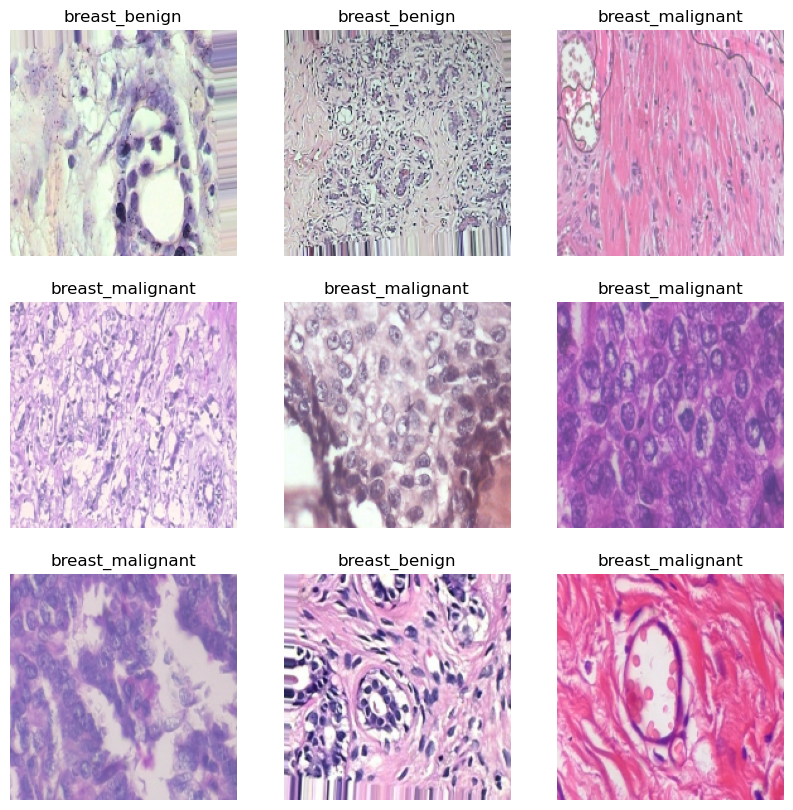

In [3]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Standardize the data

In [4]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.0 0.9807718


## Build the model 

In [5]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

## Compile the model

In [6]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
             )

## Model Summary

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 16)        2

## Train the model

In [8]:
cnn_model = model.fit(train_ds, validation_data = val_ds, epochs = 10)

Epoch 1/10
25/25 [==============================] - 717s 27s/step - loss: 0.4295 - accuracy: 0.7928 - val_loss: 0.3103 - val_accuracy: 0.8988
Epoch 2/10
25/25 [==============================] - 510s 19s/step - loss: 0.2786 - accuracy: 0.8906 - val_loss: 0.2798 - val_accuracy: 0.9162
Epoch 3/10
25/25 [==============================] - 244s 9s/step - loss: 0.2551 - accuracy: 0.8981 - val_loss: 0.2595 - val_accuracy: 0.9150
Epoch 4/10
25/25 [==============================] - 293s 11s/step - loss: 0.2232 - accuracy: 0.9109 - val_loss: 0.2572 - val_accuracy: 0.9100
Epoch 5/10
25/25 [==============================] - 332s 11s/step - loss: 0.2194 - accuracy: 0.9125 - val_loss: 0.2673 - val_accuracy: 0.9112
Epoch 6/10
25/25 [==============================] - 257s 9s/step - loss: 0.2155 - accuracy: 0.9197 - val_loss: 0.2625 - val_accuracy: 0.8988
Epoch 7/10
25/25 [==============================] - 592s 23s/step - loss: 0.1832 - accuracy: 0.9306 - val_loss: 0.2244 - val_accuracy: 0.9200
Epoch 8/

## Save the model

In [9]:
model.save("models/breast_cancer_model.h5")

## Visualize training results

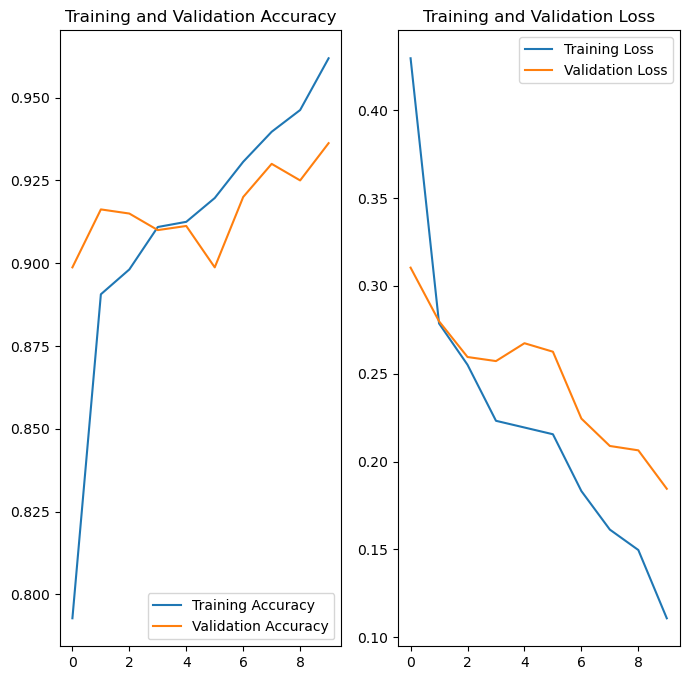

In [10]:
acc = cnn_model.history['accuracy']
val_acc = cnn_model.history['val_accuracy']

loss = cnn_model.history['loss']
val_loss = cnn_model.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

In [ ]:
image_url = "dataset/Brain Cancer/Testing/brain_menin/brain_menin_2514.jpg"

img = tf.keras.utils.load_img(
    image_url, target_size = (180, 180)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(len(predictions))
print("This image is most likely a {} with a {:.2f} percent confidence"
      .format(class_names[np.argmax(score)], 100 * np.max(score))
     )
predictions